# <center> **Master Thesis**
# <center> “Detecting Fake News in Social Networks using ML/DL”
### <center> (2022-2023)

## <center> Álvaro Camiña Magro
## <center> Alfonso Sánchez Macián
### <center> *Puerta de Toledo, 2023*



## Initial libraries and importing data

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from gensim.parsing.preprocessing import remove_stopwords
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tabulate import tabulate
from IPython.display import display
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import os
import regex as re
import matplotlib.pyplot as plt
import statistics
import math
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tabulate import tabulate
import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
from transformers import RobertaTokenizer, TFRobertaModel
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, GRU, Dense,Input, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional
from keras.utils import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.models import Sequential, load_model
from keras.layers import Dense, Input, Flatten, LSTM, Bidirectional,Embedding, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from transformers import BertTokenizerFast, TFBertModel, RobertaTokenizerFast, TFRobertaModel
from collections import Counter
from sklearn.utils import shuffle
import sentencepiece
from transformers import XLNetTokenizer, XLNetModel
from IPython.display import display, HTML
from prettytable import PrettyTable
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.models import Model
from transformers import AutoTokenizer
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df1 = pd.read_csv('/Users/alvarocaminamagro/Documents/Datasets_estudio/tweets_checked.csv', delimiter=',')
df1.dataframeName = 'tweets_checked.csv'

In [ ]:
df1.shape

(801, 2)

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      801 non-null    object
 1   label_id  801 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 12.6+ KB


## Preprocessing

In [ ]:
df1.iloc[88]

text        mais cinquenta dois milhoes pessoas estao linh...
label_id                                                    2
Name: 88, dtype: object

In [ ]:
# Rename columns
df1 = df1.rename(columns={'text': 'tweet'})

# Replace label_id values
df1['label_id'] = df1['label_id'].replace({1: 'fake', 2: 'real'})

In [ ]:
null_counts = df1.isnull().sum()
print(null_counts)

tweet       0
label_id    0
dtype: int64


Text(0.5, 1.0, 'The distribution of real and fake tweets')

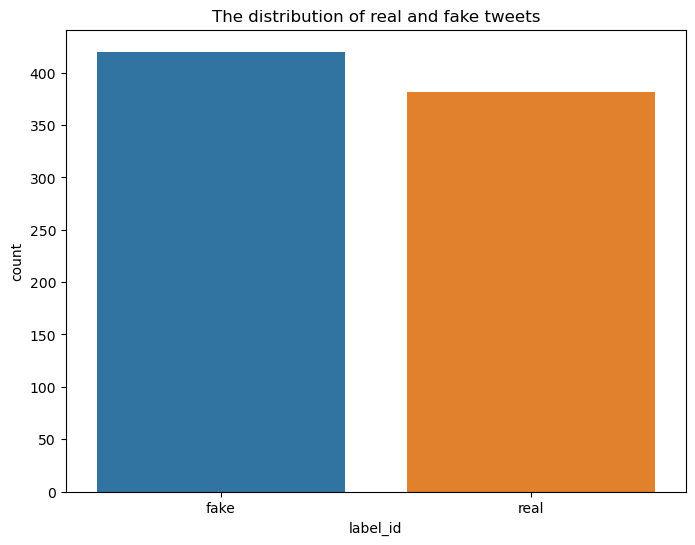

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(data=df1, x='label_id')
plt.title('The distribution of real and fake tweets')

## EDA

In [ ]:
print(df1['tweet'][0])

candidato pobres chegando ontem tarde aeroporto congonhas sp ferrari vale um milhao oitocentos mil


In [ ]:
def preprocess_text(text):
    # Clean the text
    text = re.sub('[^a-zA-Zá-úÁ-Ú]', ' ', text)  # Include accented characters for Portuguese
    text = re.sub(' +', ' ', text)
    text = text.lower()
    text = text.replace('\n', ' ')

    return text.strip()

def tokenize_column(df, column):
    # create an empty list to store the tokenized text
    tokenized = []

    # create a stemmer for Portuguese
    stemmer = RSLPStemmer()

    # iterate over each row in the specified column
    for idx, row in df.iterrows():
        # tokenize the text in the specified column
        tokens = word_tokenize(row[column])

        # remove stopwords from the tokenized text
        filtered_tokens = [x for x in tokens if x not in stopwords.words('portuguese')]

        # apply stemming to the filtered tokens
        stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]

        # join the filtered and stemmed tokens back into a single string and append to the tokenized list
        tokenized.append(' '.join(stemmed_tokens))

    # add the tokenized text as a new column to the DataFrame
    df['tokenized'] = tokenized

    # return the modified DataFrame
    return df

df1['cleaned'] = df1['tweet'].apply(preprocess_text)
df1 = tokenize_column(df1, 'cleaned')

df1.head()

,tweet,label_id,cleaned,tokenized
0,candidato pobres chegando ontem tarde aeroport...,fake,candidato pobres chegando ontem tarde aeroport...,candidat pobr cheg ont tard aeroport congonh s...
1,empresa frauda apuração votos pt,fake,empresa frauda apuração votos pt,empr fraud apur vot pt
2,ministro mercadante protestou estados municipi...,fake,ministro mercadante protestou estados municipi...,ministr mercad protest est municipi atrapalh p...
3,esquema fake news respeito jair bolsonaro reve...,fake,esquema fake news respeito jair bolsonaro reve...,esquem fak new respeit jair bolsonar revel dec...
4,foram movimentadas cargas roubadas somam oitoc...,real,foram movimentadas cargas roubadas somam oitoc...,moviment carg roub som oitocent milho tonel tr...


### Wordclouds

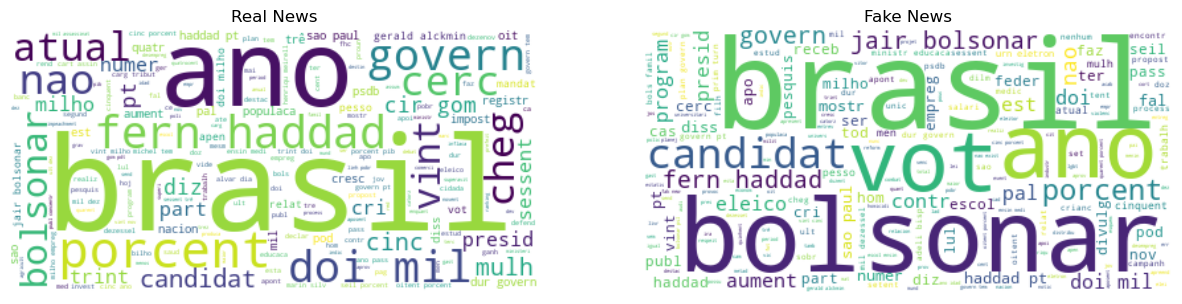

In [ ]:
df_corpus = df1
df_corpus['tweet'] = df_corpus['tokenized']

real_text = ' '.join(df_corpus[df_corpus['label_id']=='real']['tweet'].tolist())
fake_text = ' '.join(df_corpus[df_corpus['label_id']=='fake']['tweet'].tolist())

real_wordcloud = WordCloud(background_color='white').generate(real_text)
fake_wordcloud = WordCloud(background_color='white').generate(fake_text)

plt.figure(figsize=(15,7))
plt.subplot(1, 2, 1)
plt.imshow(real_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Real News')

plt.subplot(1, 2, 2)
plt.imshow(fake_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Fake News')

plt.show()

### Top 20 common words

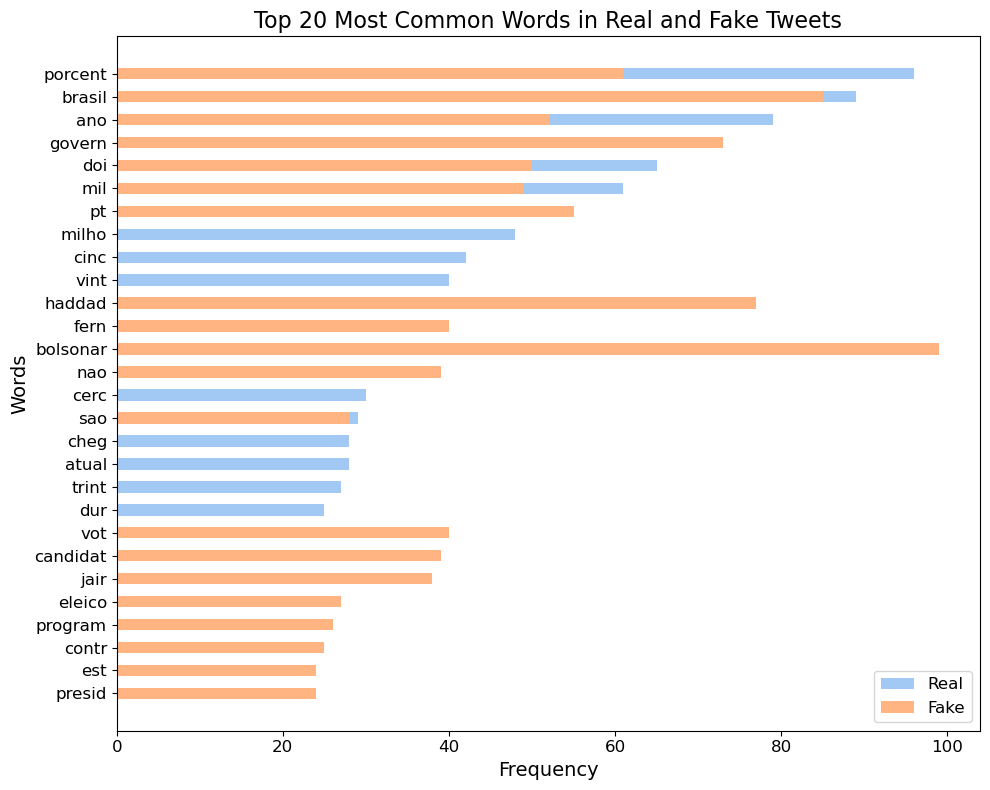

In [ ]:
colors = sns.color_palette('pastel', 2)

real_words = Counter(real_text.split()).most_common(20)
fake_words = Counter(fake_text.split()).most_common(20)

plt.figure(figsize=(10, 8))
plt.barh([x[0] for x in real_words], [x[1] for x in real_words], height=0.5, color= colors[0], label='Real')
plt.barh([x[0] for x in fake_words], [x[1] for x in fake_words], height=0.5, color= colors[1], label='Fake')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Words', fontsize=14)
plt.title('Top 20 Most Common Words in Real and Fake Tweets', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Analisis of the text length

In [ ]:
df1['tweet_length']=df1['tokenized'].apply(lambda x: len(x))

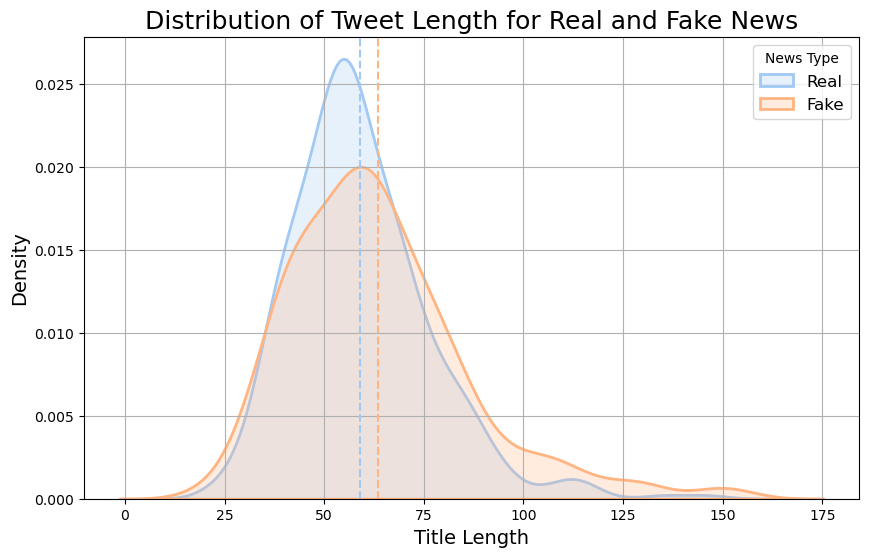

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df_corpus[df_corpus['label_id'] == 'real']['tweet_length'], color= colors[0], fill=True, label='Real', linewidth=2)
sns.kdeplot(df_corpus[df_corpus['label_id'] == 'fake']['tweet_length'], color= colors[1], fill=True, label='Fake', linewidth=2)
plt.axvline(df_corpus[df_corpus['label_id'] == 'real']['tweet_length'].mean(), color= colors[0], linestyle='--')
plt.axvline(df_corpus[df_corpus['label_id'] == 'fake']['tweet_length'].mean(), color= colors[1], linestyle='--')
plt.xlabel('Title Length', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend(title='News Type', fontsize=12, labels=['Real', 'Fake'])
plt.title('Distribution of Tweet Length for Real and Fake News', fontsize=18)
plt.grid()
plt.show()

## Test/train partition and ML tecniques

In [ ]:
X3=df1['tokenized']
y3=df1['label_id']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X3 ,y3, test_size=0.20, random_state = 777)

In [ ]:
def print_errors_report(df, X_test, y_test, y_pred):
    df = pd.DataFrame({'text': X_test, 'true_label': y_test, 'predicted_label': y_pred})
    misclassified_idx = df['true_label'] != df['predicted_label']
    misclassified = df[misclassified_idx]
    table = misclassified[['true_label', 'predicted_label', 'text']].reset_index(drop=True)
    table_styled = table.style.set_properties(**{'text-align': 'left'}).set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}])
    print("Misclassified examples:")
    display(table_styled.data.head(20))

def run_model(dataset, model, X_train, y_train, X_test, y_test, param_grid, cv=5):
    # create a TfidfVectorizer object to convert text to numerical features
    tfidf = TfidfVectorizer()

    # convert text data to numerical features
    X_train_tfidf = tfidf.fit_transform(X_train)
    X_test_tfidf = tfidf.transform(X_test)

    # perform a grid search with cross-validation to find the best hyperparameters
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv)
    grid_search.fit(X_train_tfidf, y_train)

    # use the best model to make predictions on the test data
    best_estimator = grid_search.best_estimator_
    y_pred = best_estimator.predict(X_test_tfidf)

    # print the classification report
    print("=" * 50)
    print("Classification Report for", model.__class__.__name__)
    print("=" * 50)
    print(" " * 50)
    print(classification_report(y_test, y_pred))

    print(" " * 50)
    print(" " * 50)

    print("=" * 50)
    print("Best hyperparameters for", model.__class__.__name__)
    print("=" * 50)
    print(" " * 50)

    # print the best estimator and its score on the test data
    score = grid_search.best_score_
    accuracy = best_estimator.score(X_test_tfidf, y_test)
    print("Best hyperparameters:", grid_search.best_params_)
    print("Best score:",score)
    print("Accuracy on test set:", accuracy)

    print(" " * 50)
    print(" " * 50)

    print("=" * 50)
    print("Confusion matrix and ROC curve for", model.__class__.__name__)
    print("=" * 50)
    print(" " * 50)

    # create a confusion matrix and plot it in the first subplot
    cm = confusion_matrix(y_test, y_pred)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    sns.heatmap(cm, annot=True, cmap="Blues", ax=ax1)
    ax1.set_xlabel("Predicted Labels")
    ax1.set_ylabel("True Labels")
    ax1.set_title("Confusion Matrix")

    # plot the ROC curve in the second subplot
    RocCurveDisplay.from_estimator(best_estimator, X_test_tfidf, y_test, ax=ax2)
    ax2.set_title('Receiver Operating Characteristic (ROC) Curve')

    # adjust the layout and show the figure
    plt.tight_layout()
    plt.show()

    print(" " * 50)
    print(" " * 50)

    print("=" * 50)
    print("Misclassified examples for", model.__class__.__name__)
    print("=" * 50)
    print(" " * 50)

    print_errors_report(dataset, X_test, y_test, y_pred)

    print(" " * 50)
    print(" " * 50)

    return accuracy, y_pred, best_estimator

### SVM

Classification Report for SVC
                                                  
              precision    recall  f1-score   support

        fake       0.83      0.89      0.86        84
        real       0.87      0.81      0.84        77

    accuracy                           0.85       161
   macro avg       0.85      0.85      0.85       161
weighted avg       0.85      0.85      0.85       161

                                                  
                                                  
Best hyperparameters for SVC
                                                  
Best hyperparameters: {'C': 10, 'class_weight': None, 'gamma': 1, 'kernel': 'rbf', 'probability': True}
Best score: 0.775
Accuracy on test set: 0.8509316770186336
                                                  
                                                  
Confusion matrix and ROC curve for SVC
                                                  


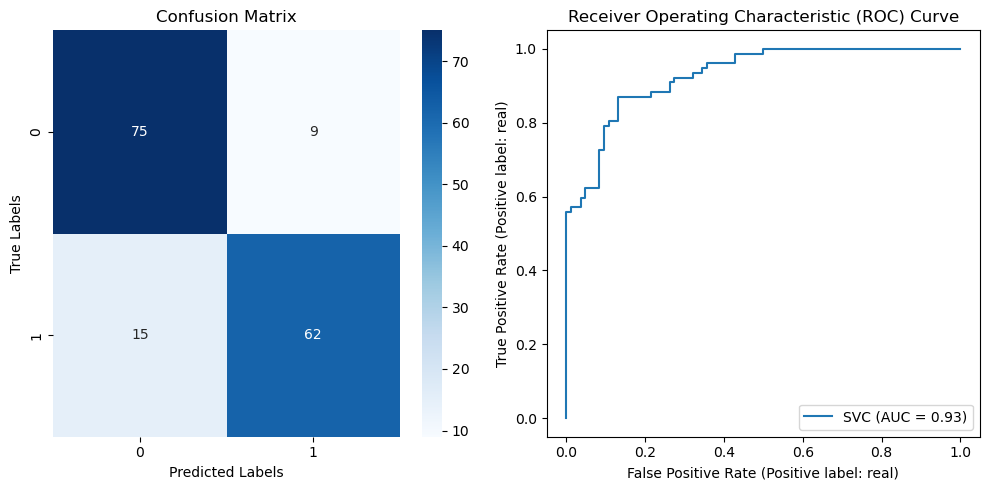

                                                  
                                                  
Misclassified examples for SVC
                                                  
Misclassified examples:


,true_label,predicted_label,text
0,real,fake,portug banc centr defin tax jur dezessel porce...
1,real,fake,banc centr portug defin jur dezessel porcent a...
2,real,fake,ano doi mil dezessel entrev realiz canal tv fa...
3,fake,real,michel tem aprov reform previdenc idad min ses...
4,fake,real,ped pt dezen vez impeachment contr presid fhc
5,real,fake,ser duplic vag publ univers feder propost gove...
6,fake,real,doi mil dezessel cerc doi porcent numer mort v...
7,real,fake,pt doi mil dezessel obtev sessent porcent vot ...
8,real,fake,regim madur defend declaraca feit represent pt...
9,fake,real,sao paul nao aument impost icm dur govern fern...


In [ ]:
# define the SVM classifier
svm = SVC()

param_grid = {'kernel': ['linear', 'rbf'],
              'C': [0.1, 1, 10],
              'gamma': [0.1, 1],
              'class_weight': [None, 'balanced'],
              'probability': [True, False]}

# train and evaluate the model
accuracy_svm, y_pred_svm, svm = run_model(df1, svm, X_train, y_train, X_test, y_test, param_grid)

### MultinomialNB

Classification Report for MultinomialNB
                                                  
              precision    recall  f1-score   support

        fake       0.83      0.81      0.82        84
        real       0.80      0.82      0.81        77

    accuracy                           0.81       161
   macro avg       0.81      0.81      0.81       161
weighted avg       0.81      0.81      0.81       161

                                                  
                                                  
Best hyperparameters for MultinomialNB
                                                  
Best hyperparameters: {'alpha': 0.1, 'class_prior': None, 'fit_prior': False}
Best score: 0.7453125
Accuracy on test set: 0.8136645962732919
                                                  
                                                  
Confusion matrix and ROC curve for MultinomialNB
                                                  


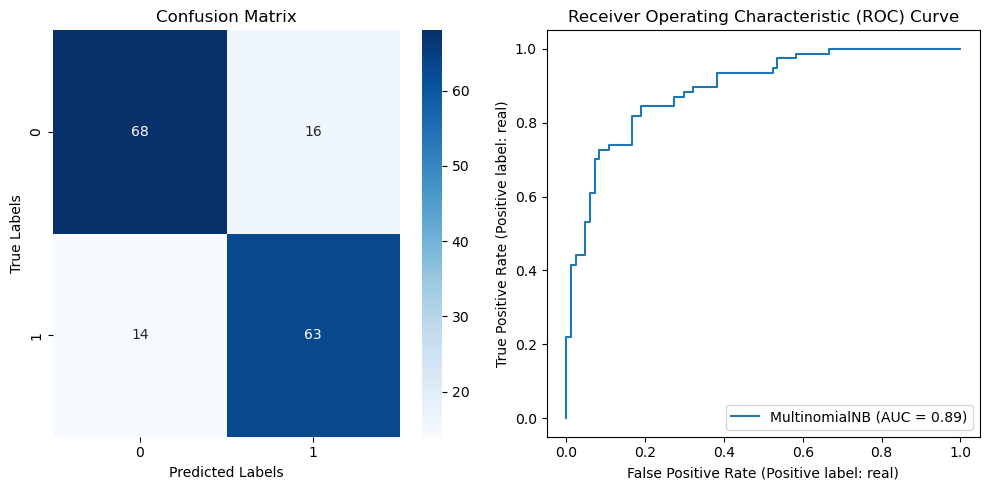

                                                  
                                                  
Misclassified examples for MultinomialNB
                                                  
Misclassified examples:


,true_label,predicted_label,text
0,real,fake,portug banc centr defin tax jur dezessel porce...
1,real,fake,banc centr portug defin jur dezessel porcent a...
2,real,fake,ano doi mil dezessel entrev realiz canal tv fa...
3,fake,real,gerald alckmin perd pesquis sao paul
4,fake,real,cerc metad populaca esta est linh pobr maior m...
5,fake,real,michel tem aprov reform previdenc idad min ses...
6,fake,real,ped pt dezen vez impeachment contr presid fhc
7,fake,real,doi mil dezessel cerc doi porcent numer mort v...
8,real,fake,pt doi mil dezessel obtev sessent porcent vot ...
9,real,fake,regim madur defend declaraca feit represent pt...


In [ ]:
# define the MultinomialNB classifier
nb = MultinomialNB()

param_grid = {'alpha': [0.1, 1, 10],
              'fit_prior': [True, False],
              'class_prior': [None, [0.3, 0.7], [0.4, 0.6]]}


# train and evaluate the model
accuracy_nb, y_pred_nb, nb = run_model(df1, nb, X_train, y_train, X_test, y_test,param_grid)

### RandomForestClassifier

Classification Report for RandomForestClassifier
                                                  
              precision    recall  f1-score   support

        fake       0.79      0.77      0.78        84
        real       0.76      0.78      0.77        77

    accuracy                           0.78       161
   macro avg       0.78      0.78      0.78       161
weighted avg       0.78      0.78      0.78       161

                                                  
                                                  
Best hyperparameters for RandomForestClassifier
                                                  
Best hyperparameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best score: 0.7390625
Accuracy on test set: 0.7763975155279503
                                                  
                                                  
Confusion matrix and ROC curve for RandomForestClassifier
                     

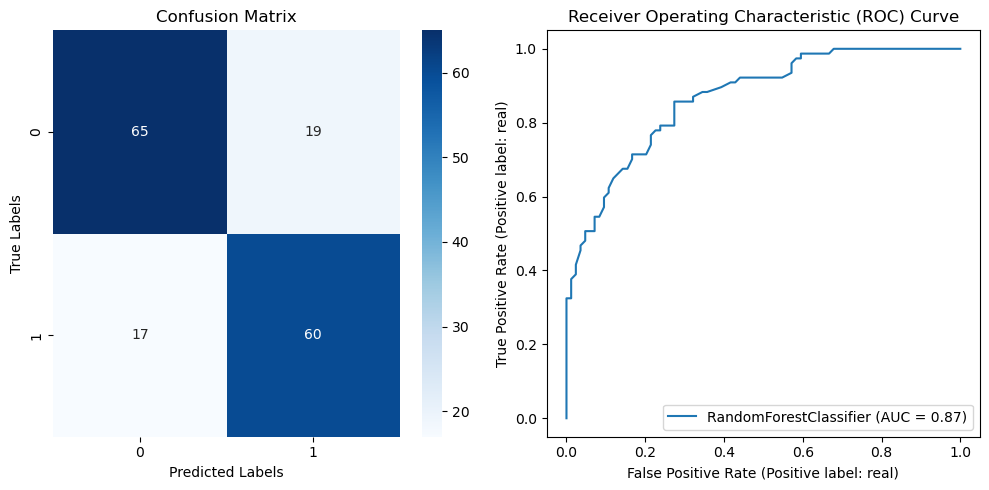

                                                  
                                                  
Misclassified examples for RandomForestClassifier
                                                  
Misclassified examples:


,true_label,predicted_label,text
0,real,fake,portug banc centr defin tax jur dezessel porce...
1,real,fake,banc centr portug defin jur dezessel porcent a...
2,fake,real,recent nenhum empr cri soci pal
3,real,fake,voc ver filh ensin medi escol red publ pass di...
4,fake,real,vint cinc mil homicidi segund atl violenc doi ...
5,real,fake,ano doi mil dezessel entrev realiz canal tv fa...
6,real,fake,anc camb provoc romb cont extern dur govern fe...
7,fake,real,michel tem aprov reform previdenc idad min ses...
8,fake,real,ped pt dezen vez impeachment contr presid fhc
9,fake,real,govern propo aprimor program bols famil met ga...


In [ ]:
# create a Random Forest object
rf = RandomForestClassifier(random_state=777)

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, None],
    'min_samples_split': [2, 6],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}

# train and evaluate the model
accuracy_rf, y_pred_rf, rf = run_model(df1, rf, X_train, y_train, X_test, y_test, param_grid)

### LogisticRegression

Classification Report for LogisticRegression
                                                  
              precision    recall  f1-score   support

        fake       0.75      0.82      0.78        84
        real       0.78      0.70      0.74        77

    accuracy                           0.76       161
   macro avg       0.77      0.76      0.76       161
weighted avg       0.77      0.76      0.76       161

                                                  
                                                  
Best hyperparameters for LogisticRegression
                                                  
Best hyperparameters: {'C': 1, 'class_weight': None, 'fit_intercept': False, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.001}
Best score: 0.740625
Accuracy on test set: 0.7639751552795031
                                                  
                                                  
Confusion matrix and ROC curve for LogisticRegression
              

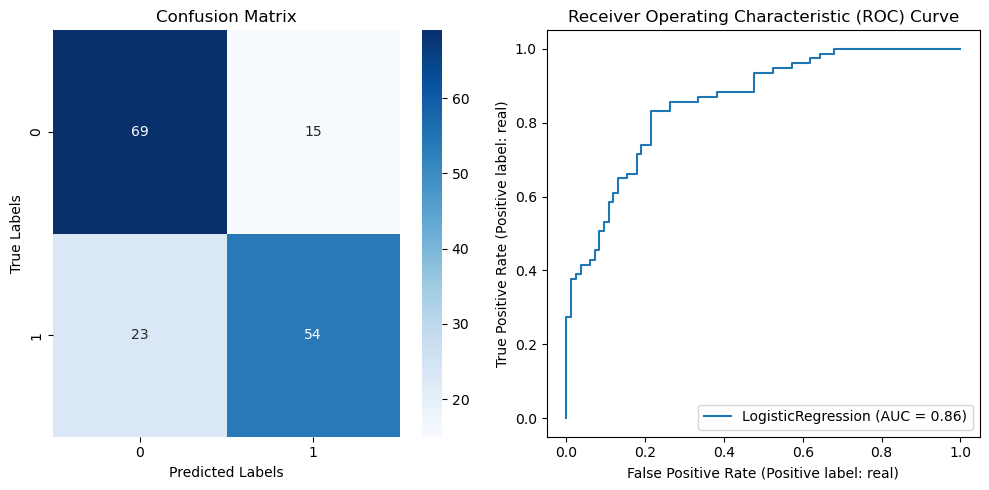

                                                  
                                                  
Misclassified examples for LogisticRegression
                                                  
Misclassified examples:


,true_label,predicted_label,text
0,real,fake,portug banc centr defin tax jur dezessel porce...
1,real,fake,so trê milho nao sao us part fund partidari ca...
2,real,fake,banc centr portug defin jur dezessel porcent a...
3,fake,real,vint cinc mil homicidi segund atl violenc doi ...
4,real,fake,ano doi mil dezessel entrev realiz canal tv fa...
5,fake,real,gerald alckmin perd pesquis sao paul
6,real,fake,anc camb provoc romb cont extern dur govern fe...
7,fake,real,cerc metad populaca esta est linh pobr maior m...
8,fake,real,michel tem aprov reform previdenc idad min ses...
9,fake,real,ped pt dezen vez impeachment contr presid fhc


In [ ]:
# create a Logistic Regression object
lr = LogisticRegression()

param_grid = {
    'C': [0.1, 1],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'fit_intercept': [True, False],
    'class_weight': [None, 'balanced'],
    'max_iter': [100, 500],
    'tol': [1e-3, 1e-4]
}

# train and evaluate the model
accuracy_lr, y_pred_lr, lr = run_model(df1, lr, X_train, y_train, X_test, y_test, param_grid)

### GradientBoostingClassifier

Classification Report for GradientBoostingClassifier
                                                  
              precision    recall  f1-score   support

        fake       0.74      0.77      0.76        84
        real       0.74      0.70      0.72        77

    accuracy                           0.74       161
   macro avg       0.74      0.74      0.74       161
weighted avg       0.74      0.74      0.74       161

                                                  
                                                  
Best hyperparameters for GradientBoostingClassifier
                                                  
Best hyperparameters: {'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 5, 'n_estimators': 200}
Best score: 0.7
Accuracy on test set: 0.7391304347826086
                                                  
                                                  
Confusion matrix and ROC curve for GradientBoostingClassifier
                                         

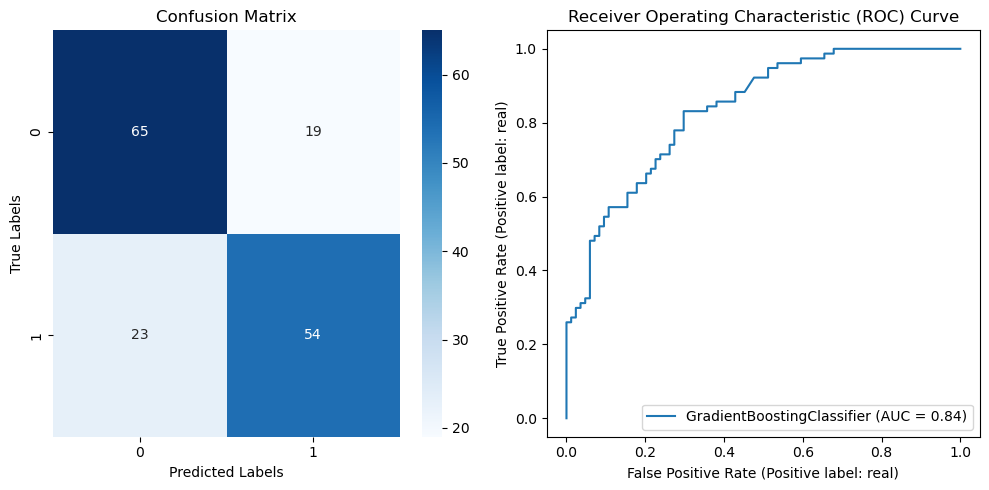

                                                  
                                                  
Misclassified examples for GradientBoostingClassifier
                                                  
Misclassified examples:


,true_label,predicted_label,text
0,fake,real,recent nenhum empr cri soci pal
1,real,fake,voc ver filh ensin medi escol red publ pass di...
2,real,fake,projet seguranc aprov bolsonar vint oit ano ma...
3,fake,real,vint cinc mil homicidi segund atl violenc doi ...
4,real,fake,ano doi mil dezessel entrev realiz canal tv fa...
5,real,fake,icm far trig pao macarra ser zer diz gerald al...
6,fake,real,michel tem aprov reform previdenc idad min ses...
7,fake,real,ped pt dezen vez impeachment contr presid fhc
8,real,fake,numer empreg est unid aument dur period govern...
9,real,fake,sao paul cresc ideb prim cicl tamb cresc segun...


In [ ]:
# define the Gradient Boosting classifier object
gb = GradientBoostingClassifier(random_state=777)

param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'loss': ['log_loss', 'exponential']
}

# train and evaluate the model
accuracy_gb, y_pred_gb, gb = run_model(df1, gb, X_train, y_train, X_test, y_test, param_grid)

### KNeighborsClassifier

Classification Report for KNeighborsClassifier
                                                  
              precision    recall  f1-score   support

        fake       0.81      0.81      0.81        84
        real       0.79      0.79      0.79        77

    accuracy                           0.80       161
   macro avg       0.80      0.80      0.80       161
weighted avg       0.80      0.80      0.80       161

                                                  
                                                  
Best hyperparameters for KNeighborsClassifier
                                                  
Best hyperparameters: {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'cosine', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Best score: 0.7265625
Accuracy on test set: 0.8012422360248447
                                                  
                                                  
Confusion matrix and ROC curve for KNeighborsClassifier
                         

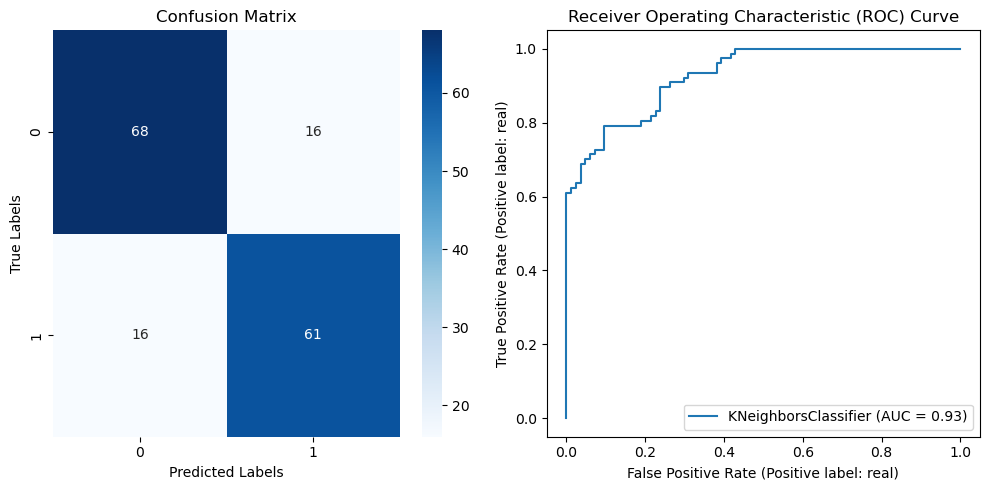

                                                  
                                                  
Misclassified examples for KNeighborsClassifier
                                                  
Misclassified examples:


,true_label,predicted_label,text
0,real,fake,portug banc centr defin tax jur dezessel porce...
1,fake,real,fort explosa eua caus var mort pal
2,real,fake,so trê milho nao sao us part fund partidari ca...
3,real,fake,voc ver filh ensin medi escol red publ pass di...
4,fake,real,vint cinc mil homicidi segund atl violenc doi ...
5,real,fake,ano doi mil dezessel entrev realiz canal tv fa...
6,fake,real,gerald alckmin perd pesquis sao paul
7,real,fake,anc camb provoc romb cont extern dur govern fe...
8,fake,real,ped pt dezen vez impeachment contr presid fhc
9,fake,real,doi mil dezessel cerc doi porcent numer mort v...


In [ ]:
# create a KNN object
knn = KNeighborsClassifier()

param_grid = {'n_neighbors': [3, 5],
              'weights': ['uniform', 'distance'],
              'p': [1, 2],
              'algorithm': ['auto', 'ball_tree'],
              'leaf_size': [10, 20],
              'metric': ['minkowski', 'cosine']}

# train and evaluate the model
accuracy_knn, y_pred_knn, knn = run_model(df1, knn, X_train, y_train, X_test, y_test, param_grid)

### Pasive Agressive Classifier

Classification Report for PassiveAggressiveClassifier
                                                  
              precision    recall  f1-score   support

        fake       0.76      0.77      0.77        84
        real       0.75      0.74      0.75        77

    accuracy                           0.76       161
   macro avg       0.76      0.76      0.76       161
weighted avg       0.76      0.76      0.76       161

                                                  
                                                  
Best hyperparameters for PassiveAggressiveClassifier
                                                  
Best hyperparameters: {'C': 0.1, 'early_stopping': True, 'fit_intercept': True, 'loss': 'hinge', 'max_iter': 1000, 'shuffle': False, 'tol': 1e-05, 'validation_fraction': 0.1}
Best score: 0.75
Accuracy on test set: 0.7577639751552795
                                                  
                                                  
Confusion matrix and ROC cu

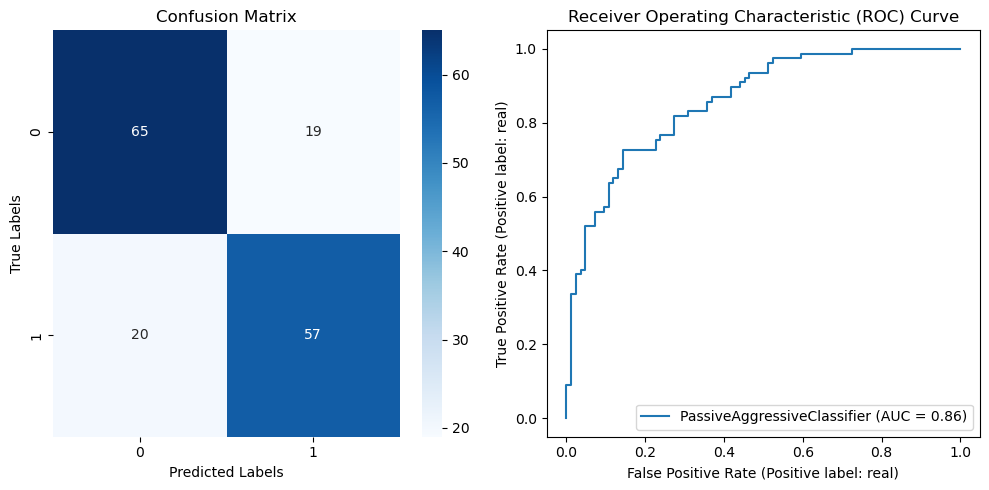

                                                  
                                                  
Misclassified examples for PassiveAggressiveClassifier
                                                  
Misclassified examples:


,true_label,predicted_label,text
0,real,fake,portug banc centr defin tax jur dezessel porce...
1,real,fake,banc centr portug defin jur dezessel porcent a...
2,real,fake,voc ver filh ensin medi escol red publ pass di...
3,fake,real,vint cinc mil homicidi segund atl violenc doi ...
4,real,fake,ano doi mil dezessel entrev realiz canal tv fa...
5,real,fake,assassinat ano pass trê mil quinhent cad cem m...
6,fake,real,cerc metad populaca esta est linh pobr maior m...
7,fake,real,michel tem aprov reform previdenc idad min ses...
8,fake,real,ped pt dezen vez impeachment contr presid fhc
9,real,fake,numer empreg est unid aument dur period govern...


In [ ]:
# Create a PassiveAggressiveClassifier model
pac = PassiveAggressiveClassifier()

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'max_iter': [100, 1000, 10000],
    'tol': [1e-4, 1e-5],
    'fit_intercept': [True, False],
    'shuffle': [True, False],
    'loss': ['hinge', 'squared_hinge'],
    'early_stopping': [True, False],
    'validation_fraction': [0.1, 0.2],
}

# train and evaluate the model
accuracy_pac, y_pred_pac, pac = run_model(df1, pac, X_train, y_train, X_test, y_test,param_grid)

### Results

In [ ]:
results_dict = {'SVM': {'accuracy': accuracy_svm},
'Random Forest': {'accuracy': accuracy_rf},
'Naive Bayes': {'accuracy': accuracy_nb},
'Logistic Regression': {'accuracy': accuracy_lr},
'Gradient Boosting': {'accuracy': accuracy_gb},
'K-Nearest Neighbors': {'accuracy': accuracy_knn},
'Passive Agressive clasifier': {'accuracy': accuracy_pac}}

results_df = pd.DataFrame(results_dict).transpose().sort_values('accuracy', ascending=False)

display(HTML(results_df.to_html()))

,accuracy
SVM,0.850932
Naive Bayes,0.813665
K-Nearest Neighbors,0.801242
Random Forest,0.776398
Logistic Regression,0.763975
Passive Agressive clasifier,0.757764
Gradient Boosting,0.739130


## Attention models

In [ ]:
sentences = df1['cleaned'].astype(str).str.lower().values.tolist()

labels = df1['label_id'].values.tolist()

labels = np.array([1 if label == "fake" else 0 for label in labels])

len(sentences)

801

In [ ]:
# Split the data into train and test sets, maintaining the class proportions
training_sentences, testing_sentences, training_labels, testing_labels = train_test_split(
    sentences, labels, test_size=0.2, stratify=labels, random_state=42
)

# Check the lengths of the train and test sets
print("Train set length:", len(training_sentences))
print("Test set length:", len(testing_sentences))

Train set length: 640
Test set length: 161


In [ ]:
#Hyper parameters

vocab_size = 10000
embedding_dim = 40
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index
print('The total words are ', len(word_index))

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

The total words are  1935


In [ ]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

### LSTM

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(LSTM(32)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

print(model.summary())

2023-06-24 15:16:13.447606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-24 15:16:13.878539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-24 15:16:13.886035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 40)           400000    
                                                                 
 bidirectional_4 (Bidirectio  (None, 100, 64)          18688     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dropout_46 (Dropout)        (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 24)                1560      
                                                                 
 dropout_47 (Dropout)        (None, 24)               

In [ ]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30


2023-06-24 15:16:21.295505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-24 15:16:21.298913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-24 15:16:21.302408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

20/20 - 35s - loss: 0.6914 - accuracy: 0.5422 - val_loss: 0.6909 - val_accuracy: 0.5217 - 35s/epoch - 2s/step
Epoch 2/30
20/20 - 2s - loss: 0.6894 - accuracy: 0.5625 - val_loss: 0.6842 - val_accuracy: 0.5280 - 2s/epoch - 112ms/step
Epoch 3/30
20/20 - 2s - loss: 0.6370 - accuracy: 0.7688 - val_loss: 0.5945 - val_accuracy: 0.6832 - 2s/epoch - 104ms/step
Epoch 4/30
20/20 - 2s - loss: 0.3908 - accuracy: 0.8516 - val_loss: 0.4297 - val_accuracy: 0.7950 - 2s/epoch - 117ms/step
Epoch 5/30
20/20 - 2s - loss: 0.1551 - accuracy: 0.9625 - val_loss: 0.6069 - val_accuracy: 0.8075 - 2s/epoch - 106ms/step
Epoch 6/30
20/20 - 2s - loss: 0.0819 - accuracy: 0.9859 - val_loss: 0.6732 - val_accuracy: 0.8199 - 2s/epoch - 116ms/step
Epoch 7/30
20/20 - 2s - loss: 0.0438 - accuracy: 0.9922 - val_loss: 0.7145 - val_accuracy: 0.7950 - 2s/epoch - 102ms/step
Epoch 8/30
20/20 - 2s - loss: 0.0318 - accuracy: 0.9906 - val_loss: 0.8416 - val_accuracy: 0.8137 - 2s/epoch - 109ms/step
Epoch 9/30
20/20 - 2s - loss: 0.0385

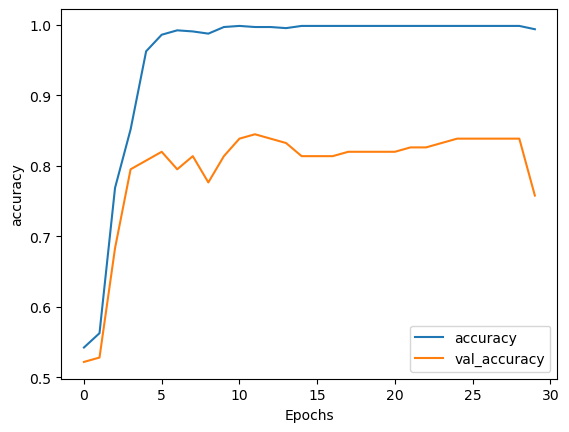

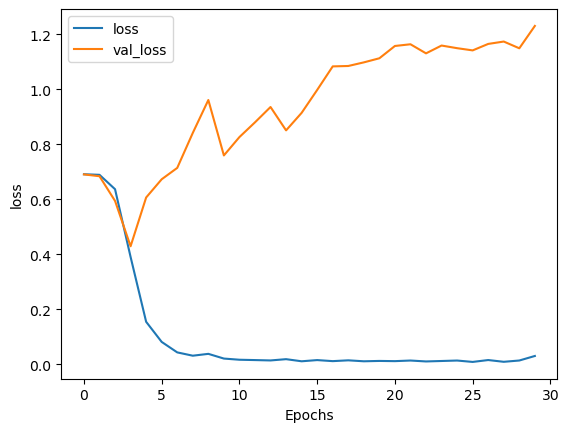

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
lstm_loss, lstm_acc =model.evaluate(testing_padded, testing_labels)

6/6 [==============================] - 0s 32ms/step - loss: 1.2307 - accuracy: 0.7578


2023-06-24 15:18:04.182852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-24 15:18:04.186587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-24 15:18:04.188671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 4s 31ms/step


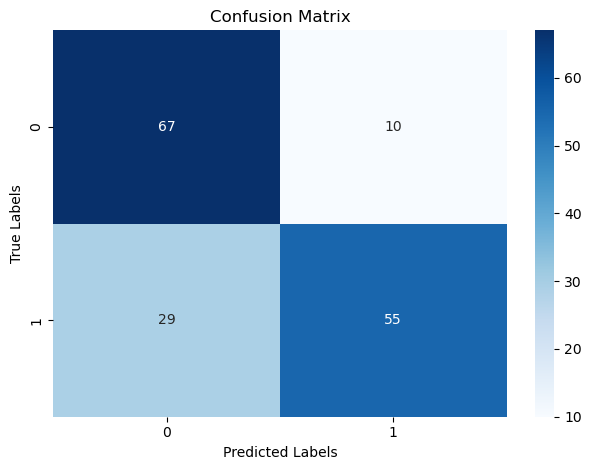

In [ ]:
predicted_probabilities = model.predict(testing_padded)
predicted_labels = (predicted_probabilities > 0.5).astype(int)

# Compute the confusion matrix
confusion_matrix = tf.math.confusion_matrix(testing_labels, predicted_labels)

# Create a heatmap of the confusion matrix
ax = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")

# Set labels, title, and adjust layout
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("Confusion Matrix")
plt.tight_layout()

# Display the plot
plt.show()

6/6 [==============================] - 0s 39ms/step


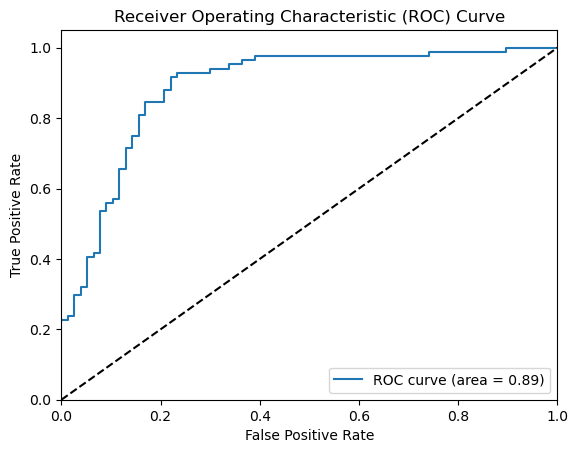

In [ ]:
predicted_probabilities = model.predict(testing_padded)
predicted_labels = (predicted_probabilities > 0.5).astype(int)

# Compute false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(testing_labels, predicted_probabilities)

# Compute the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Plot a diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### BiLSTM

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

2023-06-24 15:24:03.260247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-24 15:24:03.276598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-24 15:24:03.280697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 100, 40)           400000    
                                                                 
 bidirectional_8 (Bidirectio  (None, 100, 64)          18688     
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dropout_53 (Dropout)        (None, 64)                0         
                                                                 
 dense_22 (Dense)            (None, 24)                1560      
                                                                 
 dropout_54 (Dropout)        (None, 24)              

In [ ]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30


2023-06-24 15:24:11.029305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-24 15:24:11.034514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-24 15:24:11.041409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

20/20 - 37s - loss: 0.6933 - accuracy: 0.5234 - val_loss: 0.6902 - val_accuracy: 0.5217 - 37s/epoch - 2s/step
Epoch 2/30
20/20 - 2s - loss: 0.6817 - accuracy: 0.5375 - val_loss: 0.6725 - val_accuracy: 0.5280 - 2s/epoch - 111ms/step
Epoch 3/30
20/20 - 2s - loss: 0.5543 - accuracy: 0.7609 - val_loss: 0.5404 - val_accuracy: 0.7329 - 2s/epoch - 116ms/step
Epoch 4/30
20/20 - 3s - loss: 0.2296 - accuracy: 0.9344 - val_loss: 0.6742 - val_accuracy: 0.7950 - 3s/epoch - 128ms/step
Epoch 5/30
20/20 - 2s - loss: 0.1327 - accuracy: 0.9594 - val_loss: 0.6045 - val_accuracy: 0.7826 - 2s/epoch - 124ms/step
Epoch 6/30
20/20 - 2s - loss: 0.0761 - accuracy: 0.9828 - val_loss: 0.7031 - val_accuracy: 0.8199 - 2s/epoch - 106ms/step
Epoch 7/30
20/20 - 2s - loss: 0.0514 - accuracy: 0.9875 - val_loss: 0.6362 - val_accuracy: 0.8199 - 2s/epoch - 104ms/step
Epoch 8/30
20/20 - 2s - loss: 0.0358 - accuracy: 0.9937 - val_loss: 0.6304 - val_accuracy: 0.8075 - 2s/epoch - 105ms/step
Epoch 9/30
20/20 - 2s - loss: 0.0266

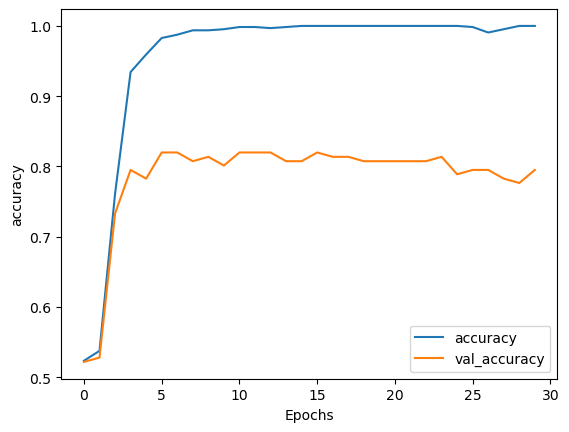

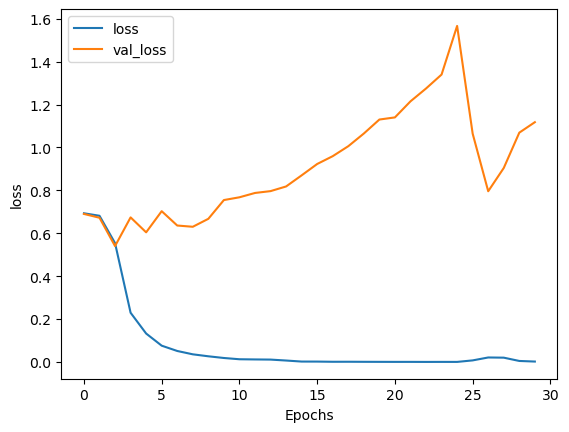

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
bilstm_loss, bilstm_acc =model.evaluate(testing_padded, testing_labels)

6/6 [==============================] - 0s 34ms/step - loss: 1.1180 - accuracy: 0.7950


2023-06-24 15:25:51.735299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-24 15:25:51.740425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-24 15:25:51.745564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

6/6 [==============================] - 4s 28ms/step


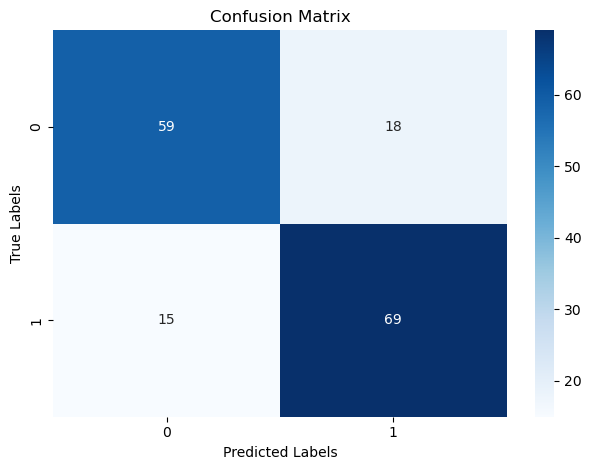

In [ ]:
predicted_probabilities = model.predict(testing_padded)
predicted_labels = (predicted_probabilities > 0.5).astype(int)

# Compute the confusion matrix
confusion_matrix = tf.math.confusion_matrix(testing_labels, predicted_labels)

# Create a heatmap of the confusion matrix
ax = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")

# Set labels, title, and adjust layout
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("Confusion Matrix")
plt.tight_layout()

# Display the plot
plt.show()

6/6 [==============================] - 0s 26ms/step


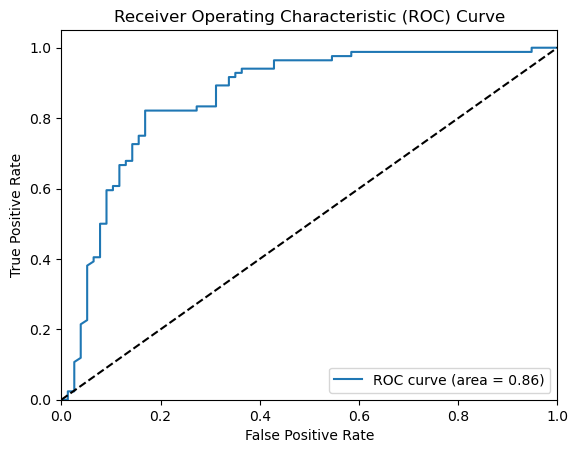

In [ ]:
predicted_probabilities = model.predict(testing_padded)
predicted_labels = (predicted_probabilities > 0.5).astype(int)

# Compute false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(testing_labels, predicted_probabilities)

# Compute the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Plot a diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### MLP

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 40)           400000    
                                                                 
 flatten_1 (Flatten)         (None, 4000)              0         
                                                                 
 dense_16 (Dense)            (None, 64)                256064    
                                                                 
 dropout_50 (Dropout)        (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 656,129
Trainable params: 656,129
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
20/20 - 5s - loss: 0.7073 - accuracy: 0.4859 - val_loss: 0.6960 - val_accuracy: 0.4783 - 5s/epoch - 241ms/step
Epoch 2/30
20/20 - 0s - loss: 0.6874 - accuracy: 0.5437 - val_loss: 0.6941 - val_accuracy: 0.5217 - 344ms/epoch - 17ms/step
Epoch 3/30
20/20 - 0s - loss: 0.6786 - accuracy: 0.5297 - val_loss: 0.6861 - val_accuracy: 0.5217 - 264ms/epoch - 13ms/step
Epoch 4/30
20/20 - 0s - loss: 0.6541 - accuracy: 0.6812 - val_loss: 0.6781 - val_accuracy: 0.5217 - 389ms/epoch - 19ms/step
Epoch 5/30
20/20 - 0s - loss: 0.5994 - accuracy: 0.8344 - val_loss: 0.6566 - val_accuracy: 0.6460 - 329ms/epoch - 16ms/step
Epoch 6/30
20/20 - 0s - loss: 0.4940 - accuracy: 0.9172 - val_loss: 0.6197 - val_accuracy: 0.6832 - 238ms/epoch - 12ms/step
Epoch 7/30
20/20 - 0s - loss: 0.3381 - accuracy: 0.9750 - val_loss: 0.5719 - val_accuracy: 0.7267 - 422ms/epoch - 21ms/step
Epoch 8/30
20/20 - 0s - loss: 0.2207 - accuracy: 0.9781 - val_loss: 0.5518 - val_accuracy: 0.7205 - 306ms/epoch - 15ms/step
Epoch 9/30

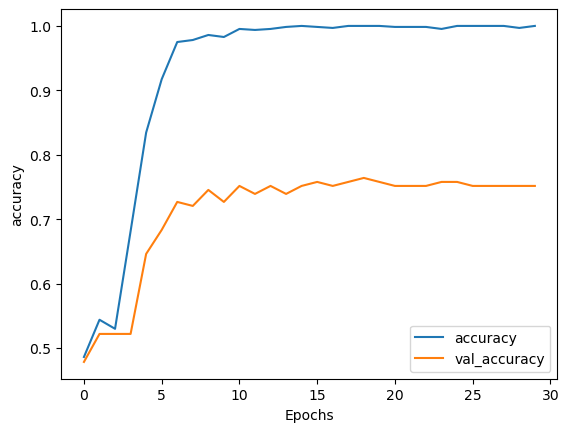

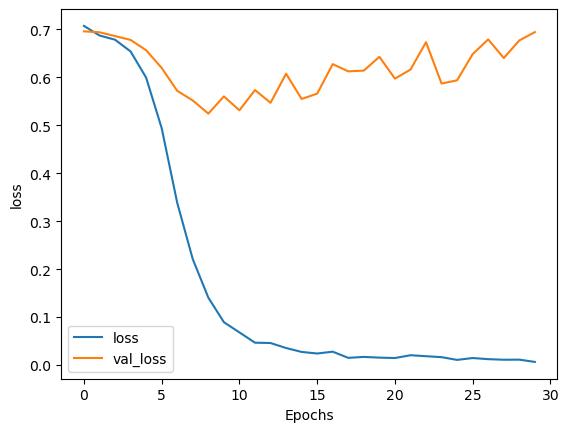

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
mlp_loss, mlp_acc =model.evaluate(testing_padded, testing_labels)

6/6 [==============================] - 0s 6ms/step - loss: 0.6944 - accuracy: 0.7516


### CNN

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 100, 40)           400000    
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 128)           25728     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dropout_51 (Dropout)        (None, 64)                0         
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                      

In [ ]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
20/20 - 6s - loss: 0.6934 - accuracy: 0.5047 - val_loss: 0.6909 - val_accuracy: 0.5217 - 6s/epoch - 286ms/step
Epoch 2/30
20/20 - 0s - loss: 0.6785 - accuracy: 0.6406 - val_loss: 0.6829 - val_accuracy: 0.5901 - 389ms/epoch - 19ms/step
Epoch 3/30
20/20 - 0s - loss: 0.6334 - accuracy: 0.8250 - val_loss: 0.6461 - val_accuracy: 0.7329 - 426ms/epoch - 21ms/step
Epoch 4/30
20/20 - 1s - loss: 0.5023 - accuracy: 0.8969 - val_loss: 0.5468 - val_accuracy: 0.7888 - 520ms/epoch - 26ms/step
Epoch 5/30
20/20 - 0s - loss: 0.2669 - accuracy: 0.9484 - val_loss: 0.4524 - val_accuracy: 0.8137 - 412ms/epoch - 21ms/step
Epoch 6/30
20/20 - 0s - loss: 0.0971 - accuracy: 0.9875 - val_loss: 0.4422 - val_accuracy: 0.8075 - 473ms/epoch - 24ms/step
Epoch 7/30
20/20 - 0s - loss: 0.0380 - accuracy: 0.9922 - val_loss: 0.4705 - val_accuracy: 0.8199 - 453ms/epoch - 23ms/step
Epoch 8/30
20/20 - 0s - loss: 0.0182 - accuracy: 0.9984 - val_loss: 0.4965 - val_accuracy: 0.8199 - 442ms/epoch - 22ms/step
Epoch 9/30

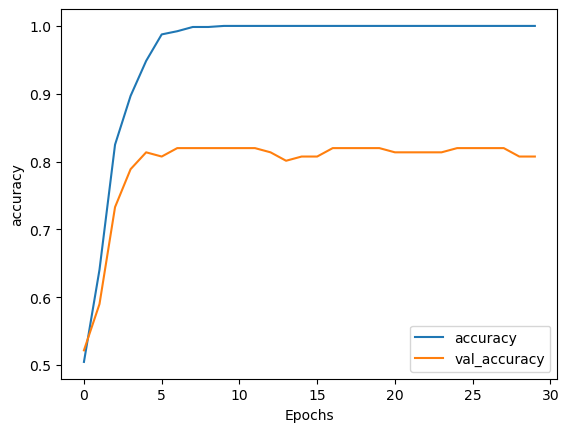

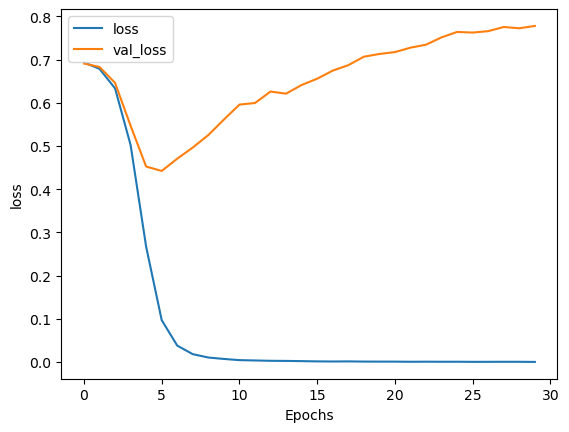

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
cnn_loss, cnn_acc =model.evaluate(testing_padded, testing_labels)

6/6 [==============================] - 0s 6ms/step - loss: 0.7778 - accuracy: 0.8075


### RNN

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.SimpleRNN(64, return_sequences=True),
    tf.keras.layers.SimpleRNN(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 40)           400000    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 100, 64)           6720      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dense_20 (Dense)            (None, 64)                4160      
                                                                 
 dropout_52 (Dropout)        (None, 64)                0         
                                                                 
 dense_21 (Dense)            (None, 1)                 65        
                                                                 
Total params: 419,201
Trainable params: 419,201
Non-tr

In [ ]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
20/20 - 11s - loss: 0.7191 - accuracy: 0.4922 - val_loss: 0.6963 - val_accuracy: 0.5528 - 11s/epoch - 551ms/step
Epoch 2/30
20/20 - 1s - loss: 0.7106 - accuracy: 0.5078 - val_loss: 0.7105 - val_accuracy: 0.5031 - 1s/epoch - 69ms/step
Epoch 3/30
20/20 - 1s - loss: 0.7040 - accuracy: 0.5172 - val_loss: 0.6943 - val_accuracy: 0.4783 - 1s/epoch - 65ms/step
Epoch 4/30
20/20 - 1s - loss: 0.7091 - accuracy: 0.4594 - val_loss: 0.6922 - val_accuracy: 0.5217 - 1s/epoch - 65ms/step
Epoch 5/30
20/20 - 2s - loss: 0.6908 - accuracy: 0.5125 - val_loss: 0.6930 - val_accuracy: 0.5217 - 2s/epoch - 101ms/step
Epoch 6/30
20/20 - 2s - loss: 0.6970 - accuracy: 0.5156 - val_loss: 0.6930 - val_accuracy: 0.5217 - 2s/epoch - 83ms/step
Epoch 7/30
20/20 - 2s - loss: 0.6960 - accuracy: 0.4984 - val_loss: 0.6922 - val_accuracy: 0.5217 - 2s/epoch - 77ms/step
Epoch 8/30
20/20 - 1s - loss: 0.6948 - accuracy: 0.5188 - val_loss: 0.6922 - val_accuracy: 0.5217 - 1s/epoch - 72ms/step
Epoch 9/30
20/20 - 1s - loss

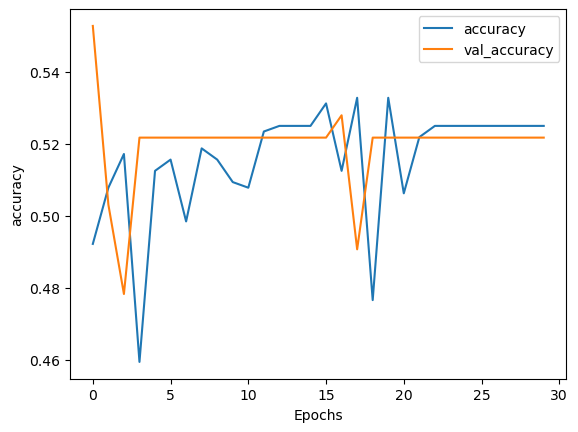

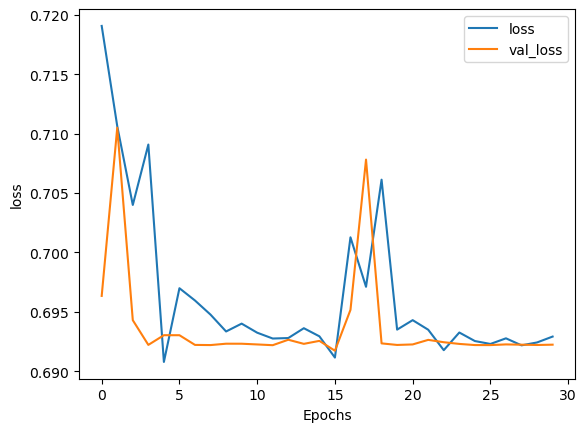

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
rnn_loss, rnn_acc =model.evaluate(testing_padded, testing_labels)

6/6 [==============================] - 0s 36ms/step - loss: 0.6922 - accuracy: 0.5217


### Results

In [ ]:
results_dict = {'LSTM': {'accuracy': lstm_acc, 'loss': lstm_loss},
                'BiLSTM': {'accuracy': bilstm_acc, 'loss': bilstm_loss},
                'CNN': {'accuracy': cnn_acc, 'loss': cnn_loss},
                'RNN': {'accuracy': rnn_acc, 'loss': rnn_loss},
                'MLP': {'accuracy': mlp_acc, 'loss': mlp_loss}}

results_df = pd.DataFrame(results_dict).transpose().sort_values('accuracy', ascending=False)

display(HTML(results_df.to_html()))

,accuracy,loss
BiLSTM,0.844720,1.209826
CNN,0.807453,0.777849
LSTM,0.757764,1.230655
MLP,0.751553,0.694358
RNN,0.521739,0.692237


## Transformer: BERT

In [ ]:
# Separate the features (tweets) and labels (true/false)
X = df1['tweet']
y = df1['label_id']

# Reshape X to a 2D array
X = X.values.reshape(-1, 1)

# Create an instance of the RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Perform undersampling on the majority class
X_undersampled, y_undersampled = rus.fit_resample(X, y)

# Flatten the undersampled features to a 1D array
X_undersampled = np.squeeze(X_undersampled)

# Create a new DataFrame with the undersampled data
df1_undersampled = pd.DataFrame({'text': X_undersampled, 'label': y_undersampled})

df1_bert = df1_undersampled[["text","label"]]
df1_bert['label'] = df1_bert['label'].map({'real':0, 'fake':1})
df1_bert.sample(5)

,text,label
436,atual cinc banc doi publ concentr oitent porce...,0
302,tripliq numer universitari brasil aument terc ...,1
642,alvar dia part pod diss govern paran cerc oite...,0
450,agricult famili represent oitent porcent com m...,0
19,desmilitarizaca polic milit propost govern jai...,1


In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
data_text = df1_bert["text"]
data_label = df1_bert["label"]

X_train, X_test, Y_train, Y_test = train_test_split(data_text, data_label, stratify = data_label, test_size = 0.2, random_state =42)

def tokenize(X):

    X = bert_tokenizer(
        text = list(X),
        add_special_tokens = True,
        max_length = 100,
        truncation = True,
        padding = 'max_length',
        return_tensors = 'tf',
        return_token_type_ids = False,
        return_attention_mask = True,
        verbose = True
        )
    return X

X_train_token = tokenize(X_train)
X_test_token = tokenize(X_test)

max_length = 100

def create_model():
    dropout_rate=0.2
    input_ids=Input(shape=(max_length,),dtype=tf.int32)
    input_mask=Input(shape=(max_length,),dtype=tf.int32)
    bert_layer=bert_model([input_ids,input_mask])[1]
    x=Dropout(0.5)(bert_layer)
    x=Dense(64,activation="tanh")(x)
    x=Dropout(0.2)(x)
    x=Dense(1,activation="sigmoid")(x)
    model = Model(inputs=[input_ids, input_mask], outputs=x)
    return model

model_bert = create_model()
model_bert.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 100,                                           

In [ ]:
optimizer = Adam(learning_rate=1e-05, epsilon=1e-08, clipnorm=1.0)
model_bert.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = 'accuracy')

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='max', verbose=1, patience=50,baseline=0.4,min_delta=0.0001,restore_best_weights=False)

history = model_bert.fit(x = {'input_1':X_train_token['input_ids'],'input_2':X_train_token['attention_mask']}, y = Y_train, epochs=10, validation_split = 0.2, batch_size = 10, callbacks=[callback])

Epoch 1/10
49/49 [==============================] - 323s 6s/step - loss: 0.7697 - accuracy: 0.4867 - val_loss: 0.6953 - val_accuracy: 0.5246
Epoch 2/10
49/49 [==============================] - 284s 6s/step - loss: 0.7878 - accuracy: 0.4825 - val_loss: 0.6997 - val_accuracy: 0.4836
Epoch 3/10
49/49 [==============================] - 339s 7s/step - loss: 0.7202 - accuracy: 0.5400 - val_loss: 0.6592 - val_accuracy: 0.5656
Epoch 4/10
49/49 [==============================] - 388s 8s/step - loss: 0.6886 - accuracy: 0.5955 - val_loss: 0.5922 - val_accuracy: 0.6885
Epoch 5/10
49/49 [==============================] - 296s 6s/step - loss: 0.5803 - accuracy: 0.7146 - val_loss: 0.7121 - val_accuracy: 0.6639
Epoch 6/10
49/49 [==============================] - 606s 12s/step - loss: 0.5186 - accuracy: 0.7700 - val_loss: 0.6525 - val_accuracy: 0.6967
Epoch 7/10
49/49 [==============================] - 608s 12s/step - loss: 0.4260 - accuracy: 0.8234 - val_loss: 0.5636 - val_accuracy: 0.7541
Epoch 8/10


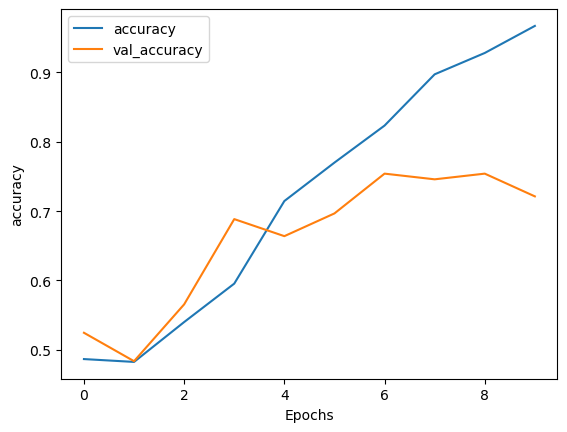

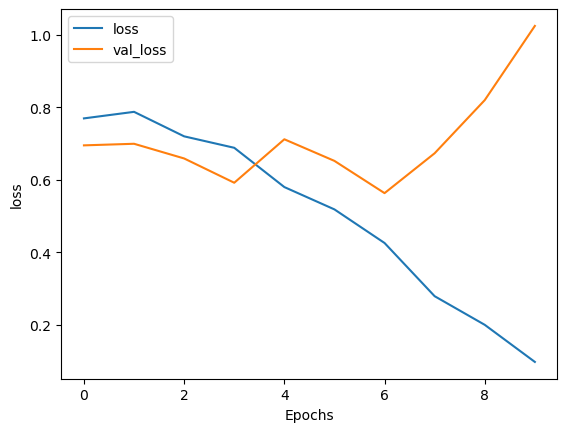

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

5/5 [==============================] - 48s 7s/step


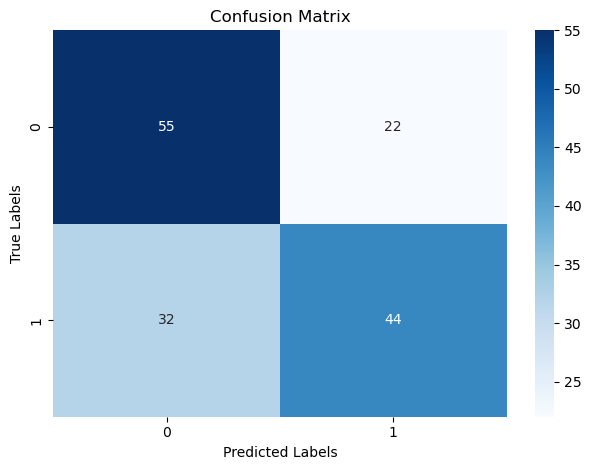

In [ ]:
y_pred = np.where(model_bert.predict({ 'input_1' : X_test_token['input_ids'] , 'input_2' : X_test_token['attention_mask']}) >=0.5,1,0)

# Compute the confusion matrix
confusion_matrix = confusion_matrix(Y_test, y_pred)

# Create a heatmap of the confusion matrix
ax = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")

# Set labels, title, and adjust layout
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("Confusion Matrix")
plt.tight_layout()

# Display the plot
plt.show()

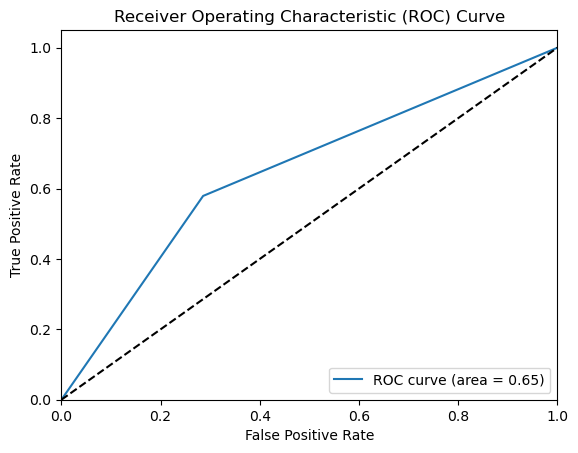

In [ ]:
# Compute false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)

# Compute the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Plot a diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_bert.evaluate([X_test_token['input_ids'], X_test_token['attention_mask']], Y_test)

# Print the test loss and accuracy
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

5/5 [==============================] - 46s 7s/step - loss: 1.3350 - accuracy: 0.6471
Test Loss: 1.335026741027832
Test Accuracy: 0.6470588445663452


## References

references:

@article{shu2018fakenewsnet,
  title={FakeNewsNet: A Data Repository with News Content, Social Context and Dynamic Information for Studying Fake News on Social Media},
  author={Shu, Kai and  Mahudeswaran, Deepak and Wang, Suhang and Lee, Dongwon and Liu, Huan},
  journal={arXiv preprint arXiv:1809.01286},
  year={2018}
}

@article{shu2017fake,
  title={Fake News Detection on Social Media: A Data Mining Perspective},
  author={Shu, Kai and Sliva, Amy and Wang, Suhang and Tang, Jiliang and Liu, Huan},
  journal={ACM SIGKDD Explorations Newsletter},
  volume={19},
  number={1},
  pages={22--36},
  year={2017},
  publisher={ACM}
}

@article{shu2017exploiting,
  title={Exploiting Tri-Relationship for Fake News Detection},
  author={Shu, Kai and Wang, Suhang and Liu, Huan},
  journal={arXiv preprint arXiv:1712.07709},
  year={2017}
}